## word2vec综述

* 做NLP，尤其是中文，要理解句子，首先要将句子切分成词语。举个例子：

  判断一个词的词性，是动词还是名词。用机器学习的思路，我们有一系列样本(x,y)，这里 x 是词语，y 是它们的词性，我们要构建 f(x)->y 的映射，但这里的数学模型 f（比如神经网络、SVM）只接受数值型输入，而 NLP 里的词语，是人类的抽象总结，是符号形式的（比如中文、英文、拉丁文等等），所以需要把他们转换成数值形式，或者说——嵌入到一个数学空间里，这种嵌入方式，就叫词嵌入（word embedding)，而 Word2vec，就是词嵌入（ word embedding) 的一种

* 至于后面如何处理向量，比如求余弦，是下次解决的问题

## 本文档主要做了下面的事情(为了减少不必要的输出，以下部分代码结果未贴出，可自行运行)

### 1.下载中文维基百科，构建语料库
### 2.数据处理： 删减不必要的信息、繁体简体转换、切词

In [ ]:
#下载维基百科中文语料库
#https://dumps.wikimedia.org/zhwiki/20190720/

使用python wikipedia extractor对上面的文件进行抽取  
进入下载文件所在目录  
命令行输入： WikiExtractor.py -o extr zhwiki-20190720-pages-articles-multistream.xml.bz2  
或者将其切分为500M：WikiExtractor.py -b 500M -o extr zhwiki-20190720-pages-articles-multistream.xml.bz2

然后装一个hanziconv 进行繁体简体转换

In [1]:
from hanziconv import HanziConv

In [2]:
%cd H:/NLP/wikiextractor-master/wikiextractor-master/extr/AA/  

H:\NLP\wikiextractor-master\wikiextractor-master\extr\AA


In [3]:
%ls 

 驱动器 H 中的卷没有标签。
 卷的序列号是 000C-862F

 H:\NLP\wikiextractor-master\wikiextractor-master\extr\AA 的目录

2019/08/04  14:49    <DIR>          .
2019/08/04  14:49    <DIR>          ..
2019/08/04  14:50        22,732,255 cut_wiki
2019/08/04  14:35       459,543,736 new_wiki_00
2019/08/04  14:40       156,296,830 new_wiki_01
2019/08/04  14:27                 0 simp_wiki_all
2019/07/30  16:15       524,287,784 wiki_00
2019/07/30  16:27       524,286,009 wiki_01
2019/07/30  16:33       306,114,856 wiki_02
2019/08/04  13:52     1,354,688,649 wiki_all
2019/07/30  20:23               323 word2vec.py
               9 个文件  3,347,950,442 字节
               2 个目录 162,914,787,328 可用字节


In [ ]:
#去掉符号  繁体-->简体转换
#对所有的wiki_** 文件执行 

ptn1 = '<.+?>' 
ptn2 = "[“”，。「」（）《》、\'·\"\-]"
 
with open('wiki_00','r',encoding='utf-8') as f,open('new_wiki_00', 'w',encoding='utf-8') as fout:
    lines = f.readlines()
    for line in lines:
        line = re.sub(ptn1, '', line)
        line = re.sub(ptn2, '', line)
        line = HanziConv.toSimplified(line)
        fout.write(line)
    print("Done!")

In [3]:
import jieba
def cut(string): return ' '.join(jieba.cut(string))

In [4]:
a = cut('这是一个测试 你好世界')
print(a,type(a))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\60230\AppData\Local\Temp\jieba.cache
Loading model cost 0.800 seconds.
Prefix dict has been built succesfully.


这是 一个 测试   你好 世界 <class 'str'>


In [ ]:
#命令行：cat  wiki_00 wiki_01 > wiki_all 合并文件
#然后分词

with open('new_wiki_00','r',encoding='utf-8') as f,open('cut_wiki', 'w',encoding='utf-8') as fout:
    lines = f.readlines()
    for i,line in enumerate(lines):
        if i % 10000 ==0: 
            print(i,line)
        fout.write(cut(line))

### 3.通过word2vec将文本进行转换： 词语—>向量

此部分在个人PC运行效率极低  
我是在百度的ai studio上运行的  
代码如下：

## 关于gensim 参数 摘自：https://blog.csdn.net/weixin_40547993/article/details/97781179
gensim工具包中详细参数：

在gensim中，word2vec相关的API都在包gensim.models.word2vec中。和算法有关的参数都在类gensim.models.word2vec.Word2Vec中。

算法需要注意的参数有：

 1) sentences: 我们要分析的语料，可以是一个列表，或者从文件中遍历读出。

 2) size: 词向量的维度，默认值是100。这个维度的取值一般与我们的语料的大小相关，如果是不大的语料，比如小于100M的文本语料，则使用默认值一般就可以了。如果是超大的语料，建议增大维度。

 3) window：即词向量上下文最大距离，这个参数在我们的算法原理篇中标记为，window越大，则和某一词较远的词也会产生上下文关系。默认值为5。在实际使用中，可以根据实际的需求来动态调整这个window的大小。如果是小语料则这个值可以设的更小。对于一般的语料这个值推荐在[5,10]之间。

 4) sg: 即我们的word2vec两个模型的选择了。如果是0，则是CBOW模型，是1则是Skip-Gram模型，默认是0即CBOW模型。

 5) hs: 即我们的word2vec两个解法的选择了，如果是0， 则是Negative Sampling，是1的话并且负采样个数negative大于0， 则是Hierarchical Softmax。默认是0即Negative Sampling。

 6) negative:即使用Negative Sampling时负采样的个数，默认是5。推荐在[3,10]之间。这个参数在我们的算法原理篇中标记为neg。

 7) cbow_mean: 仅用于CBOW在做投影的时候，为0，则算法中的为上下文的词向量之和，为1则为上下文的词向量的平均值。在我们的原理篇中，是按照词向量的平均值来描述的。个人比较喜欢用平均值来表示,默认值也是1,不推荐修改默认值。

 8) min_count:需要计算词向量的最小词频。这个值可以去掉一些很生僻的低频词，默认是5。如果是小语料，可以调低这个值。

 9) iter: 随机梯度下降法中迭代的最大次数，默认是5。对于大语料，可以增大这个值。

 10) alpha: 在随机梯度下降法中迭代的初始步长。算法原理篇中标记为，默认是0.025。

 11) min_alpha: 由于算法支持在迭代的过程中逐渐减小步长，min_alpha给出了最小的迭代步长值。随机梯度下降中每轮的迭代步长可以由iter，alpha， min_alpha一起得出。这部分由于不是word2vec算法的核心内容，因此在原理篇我们没有提到。对于大语料，需要对alpha, min_alpha,iter一起调参，来选择合适的三个值。

 12)worker：训练词向量使用时使用的线程数，默认为3。

In [ ]:
from gensim.models import word2vec
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentences = word2vec.LineSentence(u'./cut_simp_std_wiki')
model = word2vec.Word2Vec(sentences,size=200,window=5,min_count=5,workers=4)
model.save('./word2vecModel/WikiCHModel')

得到的文件合并后如下：

In [7]:
%ls

 驱动器 H 中的卷没有标签。
 卷的序列号是 000C-862F

 H:\NLP\wikiextractor-master\wikiextractor-master\wikimodel 的目录

2019/08/01  20:23    <DIR>          .
2019/08/01  20:23    <DIR>          ..
2019/08/01  20:23        22,281,123 WikiCHModel
2019/08/01  20:21       273,811,328 WikiCHModel.trainables.syn1neg.npy
2019/08/01  20:21       273,811,328 WikiCHModel.wv.vectors.npy
               3 个文件    569,903,779 字节
               2 个目录 162,914,803,712 可用字节


### 4.测试同义词

In [8]:
from gensim.models import word2vec

model = word2vec.Word2Vec.load('WikiCHModel')

print(model.wv.similarity('奥运会','金牌')) #两个词的相关性

0.5216756


In [9]:
model.wv.most_similar('金牌')

[('铜牌', 0.8520396947860718),
 ('银牌', 0.7807049751281738),
 ('奖牌', 0.7677786350250244),
 ('夺金', 0.666496217250824),
 ('冠军', 0.6213092803955078),
 ('首面', 0.6131095290184021),
 ('亚军', 0.5978277921676636),
 ('世锦赛', 0.5942174196243286),
 ('夺金牌', 0.5905194878578186),
 ('摘金', 0.5897698402404785)]

In [11]:
model.wv['金牌'][:10] #查看词向量 前10个

array([ 1.491065  , -1.7535397 ,  2.4462547 , -0.14654952,  1.1976538 ,
       -2.0326607 , -2.3107023 , -1.3593234 ,  0.10028142, -0.08600896],
      dtype=float32)

### 绘制词云（这里选的词语是‘奥运会’）

2019-08-04 15:05:08,000:INFO:loading Word2Vec object from WikiCHModel
2019-08-04 15:05:08,709:INFO:loading trainables recursively from WikiCHModel.trainables.* with mmap=None
2019-08-04 15:05:08,710:INFO:loading syn1neg from WikiCHModel.trainables.syn1neg.npy with mmap=None
2019-08-04 15:05:08,833:INFO:loading vocabulary recursively from WikiCHModel.vocabulary.* with mmap=None
2019-08-04 15:05:08,834:INFO:loading wv recursively from WikiCHModel.wv.* with mmap=None
2019-08-04 15:05:08,834:INFO:loading vectors from WikiCHModel.wv.vectors.npy with mmap=None
2019-08-04 15:05:08,981:INFO:setting ignored attribute vectors_norm to None
2019-08-04 15:05:08,982:INFO:setting ignored attribute cum_table to None
2019-08-04 15:05:08,982:INFO:loaded WikiCHModel
H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
2019-08-04 15:05:09,822:INFO:precomputing L2-norms of word w

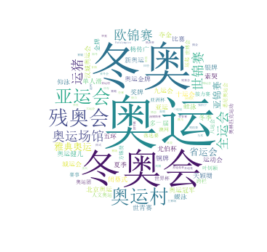

In [18]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
"""
@author:Administrator
@file:WordCloud_visualization.py
@time:2019/07/31
"""
 
import logging
from gensim import models
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
font_path = 'c:\windows\fonts\simsun.ttc'
 
'''
获取一个圆形的mask
'''
def get_mask():
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    return mask
 
'''
绘制词云
'''
def draw_word_cloud(word_cloud):
    wc = WordCloud(font_path = font_path,background_color="white", mask=get_mask())
    wc.generate_from_frequencies(word_cloud)
    # 隐藏x轴和y轴
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()
    
def test():
    logging.basicConfig(format="%(asctime)s:%(levelname)s:%(message)s", level=logging.INFO)
    model = models.Word2Vec.load("WikiCHModel")
    # 输入一个词找出相似的前100个词,默认是10个
    one_corpus = ["奥运会"]
    result = model.most_similar(one_corpus[0], topn=100)
    # 将返回的结果转换为字典,便于绘制词云
    word_cloud = dict()
    for sim in result:
        # print(sim[0],":",sim[1])
        word_cloud[sim[0]] = sim[1]
    # 绘制词云
    
    draw_word_cloud(word_cloud)
    
if __name__ == '__main__':
    test()



### 5.使用T-SEN进行词向量可视化

这里重新在AI studio上训练一个 min_count = 1000的model
因为本地训练太慢
下载下来

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    print('starting')
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    print('part 1')
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    print('part 2')
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    print('part 3')
    plt.show()

In [4]:
from gensim import models
model = models.Word2Vec.load("H:/NLP/wikiextractor-master/wikiextractor-master/wikimodel/Model_1000")

In [ ]:
tsne_plot(model)
#这里模型太大，画的太慢(浪费时间)
#我重新拿了一篇短文章做测试

starting


H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


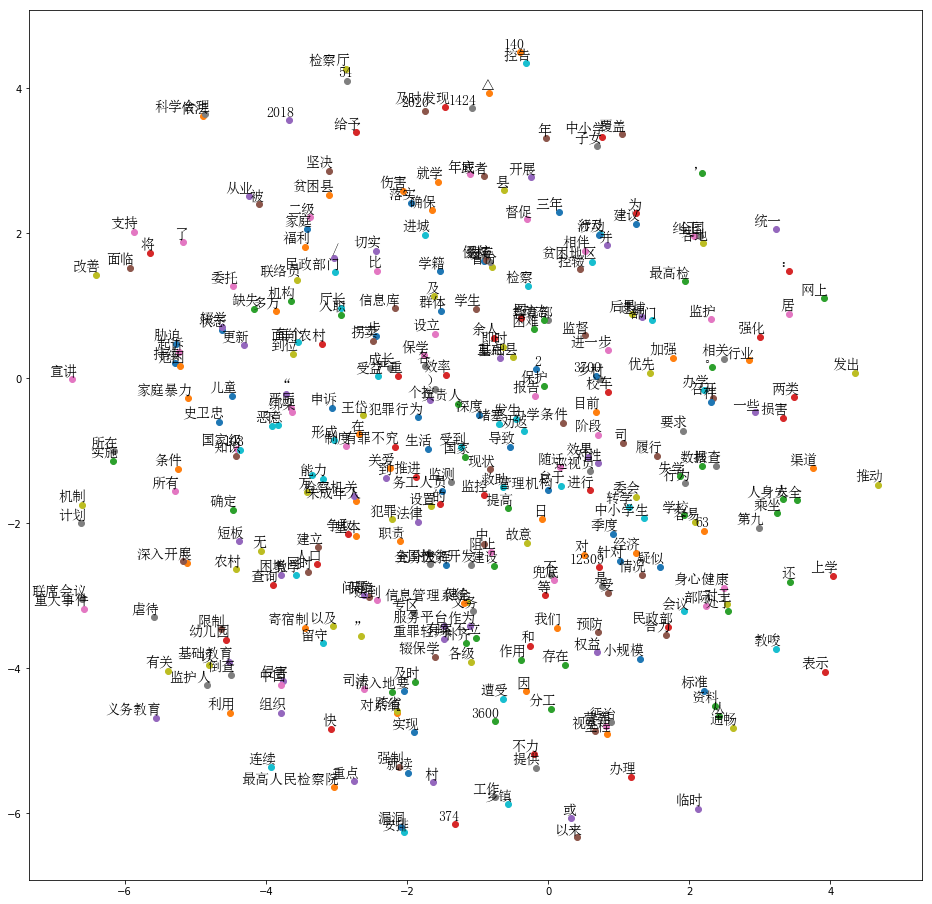

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
from gensim.models import Word2Vec
from gensim import models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

model = models.Word2Vec.load('H:/NLP/wikiextractor-master/wikiextractor-master/news_test')

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
 
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
 
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     fontproperties=font,
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(model)